# Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous notebook, we covered transfer learning featuren extraction, now it's time to learn about a new kind of transfer learning: fine-tuning.

In [ ]:
# Check if we are using a gpu
!nvidia-smi

Thu Jun 22 09:56:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper function

In previous notebooks, we've created a bunch of helper functions, now we could re-write them all, however this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import to your notebooks (or elsewhere).

We've done this for some of the functions we've used previously here:
https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-06-22 09:56:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-22 09:56:19 (67.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves,unzip_data, walk_through_dir

>🗝️**Note:** If you're running this notebook in Google Colab, when it times our Colab will delete `helper_functions.py`, so you'll have to redownload it if you want access to your helper_functions.

## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [ ]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-06-22 09:56:23--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.103.128, 108.177.121.128, 108.177.120.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.103.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   245MB/s    in 0.7s    

2023-06-22 09:56:24 (245 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
#Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [ ]:
#Create training and test directory paths
train_dir="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf

IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical',
                                                                            batch_size=BATCH_SIZE)
test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                              image_size=IMG_SIZE,
                                                              label_mode="categorical",
                                                              batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
#Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
#See an example of a batch of a data.
for images, labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[114.801025  57.80102   49.51531 ]
   [109.2602    57.117348  44.188778]
   [101.438774  51.5       51.64796 ]
   ...
   [122.71429   37.714287  60.714287]
   [117.92347   32.92347   55.92347 ]
   [122.28585   37.285854  60.285854]]

  [[110.28571   52.92857   47.      ]
   [105.42857   53.285713  42.35714 ]
   [100.85715   51.071426  51.540817]
   ...
   [121.499954  36.499954  59.499954]
   [121.        36.        59.      ]
   [120.765274  35.765274  58.765274]]

  [[112.42347   56.367348  54.510204]
   [105.27041   55.05612   46.55612 ]
   [101.92857   53.5       55.428574]
   ...
   [120.68875   35.68875   58.68875 ]
   [122.62756   37.62756   60.62756 ]
   [122.785675  37.78568   60.78568 ]]

  ...

  [[105.28576   80.28576   75.50002 ]
   [103.77043   78.77043   73.77043 ]
   [106.68875   81.26018   75.831604]
   ...
   [ 19.403118  10.403117  39.831646]
   [ 22.086687  13.086688  42.515217]
   [ 19.785706  10.785706  40.214233]]

  [[105.85712   80.85712   75.8571

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The Sequential API is straight-forward, it runs our layers in sequential OrderedDict
But the functional API gives us more flexibility with our models.

In [ ]:
# 1. Create base model with tf.keras.applications
base_model=tf.keras.applications.EfficientNetB0(include_top=False)

#2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable=False

#3. Create inputs into our model
inputs= tf.keras.layers.Input(shape=(224,224,3),name='input_layer')
#4. If using a model ResNet50v2 you will need to normalize inputs (you don't have to for EfficientNet(s))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)


#5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

#6. Average pool the outputs of the base model(aggregate all the most important information, reduce number of computations)
x=tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

#7.Create the output activation layer
outputs=tf.keras.layers.Dense(10,activation='softmax',name='output_layer')(x)

#8. Combine the inputs with the outpus into a model
model_0 = tf.keras.Model(inputs,outputs)

#9.Compile for the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

#10. Fit the model and save its history
history_0=model_0.fit(train_data_10_percent,
            epochs=5,
            steps_per_epoch=len(train_data_10_percent),
            validation_data=test_data,
            validation_steps=int(0.25*len(test_data)),
            callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                   experiment_name="10_percent_feature_extraction")])

16705208/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230622-095633


Epoch 1/5
24/24 [==============================] - 29s 252ms/step - loss: 1.8400 - accuracy: 0.4280 - val_loss: 1.2842 - val_accuracy: 0.7385
Epoch 2/5
24/24 [==============================] - 4s 141ms/step - loss: 1.0788 - accuracy: 0.7680 - val_loss: 0.8528 - val_accuracy: 0.8273
Epoch 3/5
24/24 [==============================] - 5s 184ms/step - loss: 0.7698 - accuracy: 0.8307 - val_loss: 0.6733 - val_accuracy: 0.8635
Epoch 4/5
24/24 [==============================] - 4s 137ms/step - loss: 0.6430 - accuracy: 0.8533 - val_loss: 0.6107 - val_accuracy: 0.8684
Epoch 5/5
24/24 [==============================] - 5s 174ms/step - loss: 0.5496 - accuracy: 0.8827 - val_loss: 0.5535 - val_accuracy: 0.8734


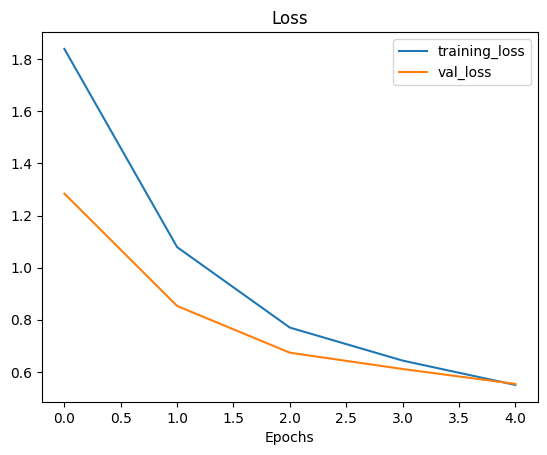

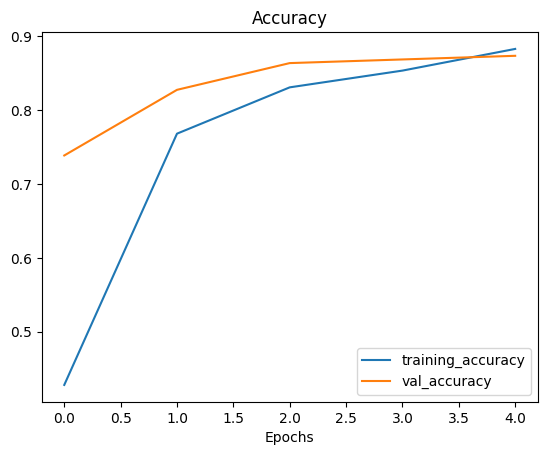

In [ ]:
plot_loss_curves(history_0)

In [ ]:
#Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 7s 82ms/step - loss: 0.5507 - accuracy: 0.8628


[0.5507131814956665, 0.8628000020980835]

In [ ]:
#Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [ ]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [ ]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


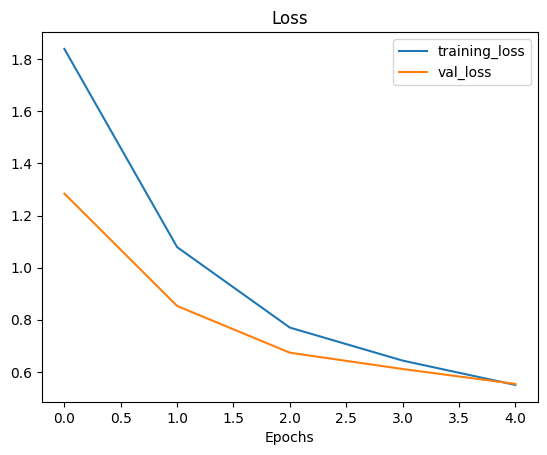

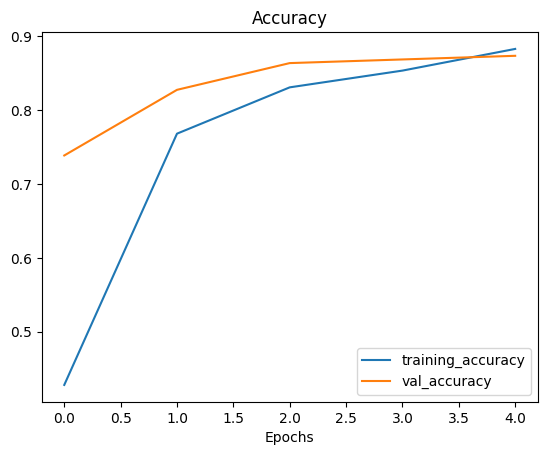

In [ ]:
# Check out our model's training curves
plot_loss_curves(history_0)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer....

We have a tensor after our model goes through `base_model` of shape(None,7,7,1280)....

But then when it passess through GlobalAveragePooling2D, it turns into (None,1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

🧠 To Know more: https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D


In [ ]:
# Define the input shape
input_shape=(1,4,4,3)

#Create a random tensor
tf.random.set_seed(42)
input_tensor=tf.random.normal(input_shape)
print(f"Random input tensor:\n{input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor=tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n{global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")


Random input tensor:
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
[[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [ ]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

🛠️**Practice:** Try to do the same with the above two cells but this time use `GlobalMaxPool2D`.. and see what happens.

In [ ]:
input_shape=(1,4,4,3)
#Create a random tensor
tf.random.set_seed(42)
input_tensor2=tf.random.normal(input_shape)
global_max_pool=tf.keras.layers.GlobalMaxPooling2D()(input_tensor)

#Print the GlobalMaxPool2D layer output and its shape
print(f"GlobalMaxPool2D random tensor:{global_max_pool}")
print(f"GlobalMaxPool2D tensor shape:{global_max_pool.shape}")
print(f"Random Tensor shape:{input_tensor.shape}")


GlobalMaxPool2D random tensor:[[0.9058464 1.1603122 1.6994323]]
GlobalMaxPool2D tensor shape:(1, 3)
Random Tensor shape:(1, 4, 4, 3)


🗝️**Note:** One of the reasons feature extraction transfer learning is named how it is because what often happens is pretrained model outputs a **feature vector** (a long tensor of numbers whch represents the learned representation of the model on a praticular sample, in our case this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can then be used to extract patterns out of for own specific problem.

**What is a feature vector?**

A feature vector is a learned representation of the input data (a compressed form of the input data based on how the model see's it)



## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data.... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10%  of the training with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning learning on 100% of the training data with data augmentation

>🗝️**Note:** throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

## Getting and preprocessing data for model_1

In [ ]:
#Download and unzip the data - preprocessed fro Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2023-06-22 09:57:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.196.128, 173.194.197.128, 64.233.191.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.196.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   108MB/s    in 1.2s    

2023-06-22 09:57:33 (108 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
#Create training and test dirs
train_dir_1_percent="10_food_classes_1_percent/train"
test_dir="10_food_classes_1_percent/test"

In [ ]:
# How many images are  we working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'

In [ ]:
# Setup data loaders
IMG_SIZE=(224,224)
train_data_1_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                         label_mode="categorical",
                                                                         image_size=IMG_SIZE,
                                                                         batch_size=BATCH_SIZE)  # Default =32

test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode='categorical',
                                                              image_size=IMG_SIZE,
                                                              batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model
To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

We can see the benefits of doing this within the TensorFlow data augmentation documentation.

When passed as a layer to a model data augmentation is automatically turned on during training (augments training data) but turned off during inference(does not augment testing data or new unseed data).

Off the top our of heads, after reading the docs, the benefits of using data augmentation inside the model are:

* Preprocessing of images(augmenting them) happens on the GPU (much faster) rather than the CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#Create data augmentation stage with horizontal flipping, rotation , zooms, etc
data_augmentation= keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
    # preprocessing.Rescaling(1./255)  # Keep the models like ResNet50V2 but EfficientNet's having rescaling built-in
],name='data_augmentation')

## Visualize our data augmentation layer (and see what happens to our data)

(-0.5, 502.5, 567.5, -0.5)

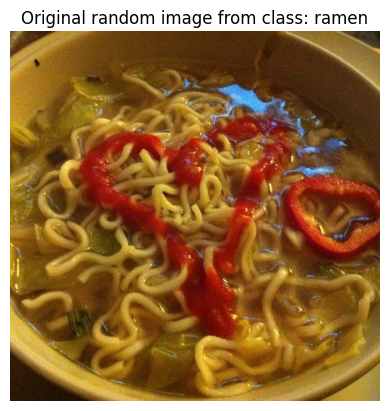

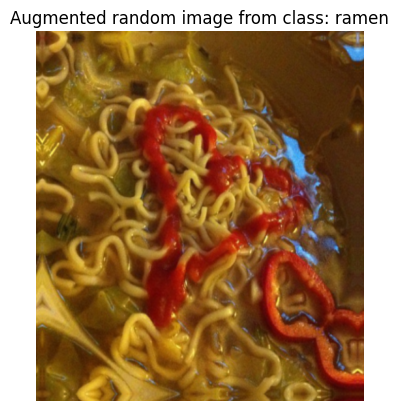

In [ ]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class=random.choice(train_data_1_percent.class_names)
target_dir="10_food_classes_1_percent/train/"+target_class
random_image=random.choice(os.listdir(target_dir))
random_image_path=target_dir+"/"+random_image

# Read and plot in the random image
img=mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False)

# Now let's plot our augmented random image
augmented_image=data_augmentation(img,training=True)
plt.figure()
plt.imshow(augmented_image/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation


In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape=(224,224,3)
base_model= tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Create the input layer
inputs=layers.Input(shape=input_shape,name="input_layer")

# Add in data augmentation Sequential model as a layer
x=data_augmentation(inputs)

#Give base_model the inputs (after augmentation) and don't train it
x=base_model(x,training=False)

#Pool output features of the base model
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

# Put a dense layer on as the output
outputs = layers.Dense(10,activation='softmax',name='output_layer')(x)

# Make a model using the inputs and the outputs
model_1 = keras.Model(inputs,outputs)

# Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_1_percent=model_1.fit(train_data_1_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_1_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25*len(test_data)),
                              #Track model training logs
                              callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                     experiment_name="1_percent_data_aug")])


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230622-095739
Epoch 1/5
3/3 [==============================] - 14s 3s/step - loss: 2.5168 - accuracy: 0.0714 - val_loss: 2.2806 - val_accuracy: 0.1447
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.2949 - accuracy: 0.2000 - val_loss: 2.1476 - val_accuracy: 0.2270
Epoch 3/5
3/3 [==============================] - 4s 1s/step - loss: 2.0371 - accuracy: 0.3286 - val_loss: 2.0548 - val_accuracy: 0.3092
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.9098 - accuracy: 0.4143 - val_loss: 1.9369 - val_accuracy: 0.3865
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6645 - accuracy: 0.5857 - val_loss: 1.8095 - val_accuracy: 0.4753


In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
#Evaluate the full test dataset
results_1_percent_data_aug=model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 68ms/step - loss: 1.8372 - accuracy: 0.4440


[1.8372156620025635, 0.4440000057220459]

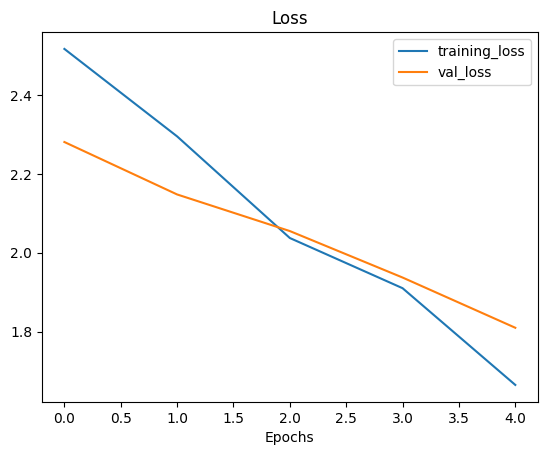

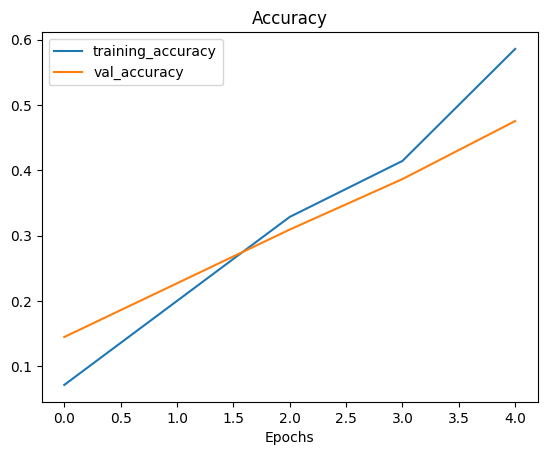

In [ ]:
# How do the model with 1% of the data and data augmentation loss curves look?
plot_loss_curves(history_1_percent)

## Model 2: feature extraction transfer learning model with 10% of data and data augmentation


In [ ]:
# Get 10% of data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip


--2023-06-22 09:58:23--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.201.128, 74.125.202.128, 74.125.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.201.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   266MB/s    in 0.6s    

2023-06-22 09:58:23 (266 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
train_dir_10_percent="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"

In [ ]:
#Set data loaders
import tensorflow as tf
IMG_SIZE=(224,224)

train_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                          label_mode='categorical',
                                                                          image_size=IMG_SIZE)
test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode='categorical',
                                                              image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# How many images are in our directories?
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [ ]:
#Create model 2 with data augmentation
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation=Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
    # preprocessing.Rescaling(1./255) #if you're using a model such as ResNet50V2, you'll need to rescale your data, efficientnet has rescalling in-built
    ],name='data_augmentation')

#Setup the input shape to our model
input_shape=(224,224,3)

#Create a frozen base model(also called the backbone)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

#Create the inputs and outputs (includig the layers in between )
inputs=layers.Input(shape=input_shape,name="input_layer")
x=data_augmentation(inputs) #augment our training images(augmentation doesn't occur on test data)
x=base_model(x,training=False)  # pass augmented images to base model but keep it in inference mode, this also insures batchnorm layers don't get updated - https://keras.io/guides/transfer_learning/#build-a-model
x= layers.GlobalAveragePooling2D(name='global_average_pooling_2D')(x)
outputs=layers.Dense(10,activation='softmax',name='output_layer')(x)

model_2=tf.keras.Model(inputs,outputs)
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])



In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### Creating a ModelCheckpoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [ ]:
# Set Checkpoint path
checkpoint_path="ten_percent_model_checkpoints_weights/checkpoint.ckpt"
#Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                       save_weights_only=True,
                                                       save_best_only=False,
                                                       save_freq="epoch", #Save every epoch
                                                       verbose=1)

## Fit the model 2 passing in ModelCheckpoint callback

In [ ]:
#Fitting the model_2
initial_epochs=5
history_2=model_2.fit(train_data_10_percent,
                      steps_per_epoch=len(train_data_10_percent),
                      epochs=initial_epochs,
                      validation_data=test_data,
                      validation_steps=int(0.25*len(test_data)),
                      callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                             experiment_name="10_percent_data_aug"),checkpoint_callback]
                      )

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230622-095827
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9925 - accuracy: 0.3507
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 26s 734ms/step - loss: 1.9925 - accuracy: 0.3507 - val_loss: 1.4588 - val_accuracy: 0.6793
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2977 - accuracy: 0.6973
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 12s 495ms/step - loss: 1.2977 - accuracy: 0.6973 - val_loss: 1.0143 - val_accuracy: 0.7648
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9886 - accuracy: 0.7800
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 13s 533ms/step - loss: 0.9886 - accuracy: 0.7800 - val_loss: 0.8126 - val_accuracy: 0.7961
E

In [ ]:
model_0.evaluate(test_data)

79/79 [==============================] - 6s 68ms/step - loss: 0.5507 - accuracy: 0.8628


[0.550713062286377, 0.8628000020980835]

In [ ]:
#Check model 2 results on all test data
results_10_percent_data_aug=model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 7s 83ms/step - loss: 0.6277 - accuracy: 0.8392


[0.6276814937591553, 0.8392000198364258]

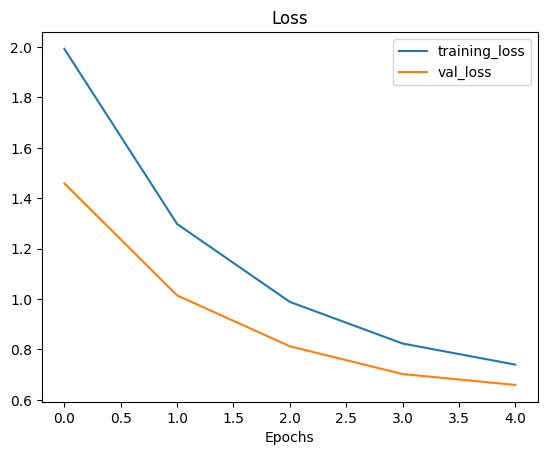

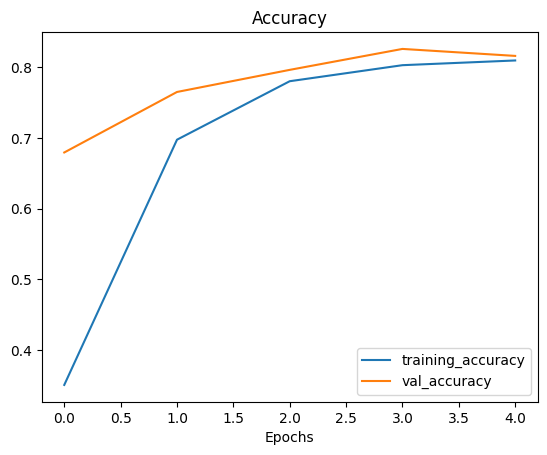

In [ ]:
# Plot model loss curves
plot_loss_curves(history_2)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint.

In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
#Evaluate model_2 with loaded weights
loaded_weights_model_results= model_2.evaluate(test_data)

79/79 [==============================] - 7s 81ms/step - loss: 0.6277 - accuracy: 0.8392


In [ ]:
# If the results from our previously evaluated model_2 match the loaded weights, everythig has worked!
results_10_percent_data_aug==loaded_weights_model_results

True

In [ ]:
results_10_percent_data_aug

[0.6276814937591553, 0.8392000198364258]

In [ ]:
loaded_weights_model_results

[0.6276814937591553, 0.8392000198364258]

In [ ]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug),np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug)-np.array(loaded_weights_model_results))

[0. 0.]


## Model 3: Fine-tuning an existing model on 10% of the data

>🗝️**Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [ ]:
model_2.layers

In [ ]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fd3e4d21060> True
<keras.engine.sequential.Sequential object at 0x7fd3d6f481c0> True
<keras.engine.functional.Functional object at 0x7fd3d6cf0a90> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fd3d6cf0310> True
<keras.layers.core.dense.Dense object at 0x7fd3d6b71bd0> True


In [ ]:
#What layers are in our base model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i,layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# To begin fine tuning let's start by setting the last 10 layers of our base_model.trainable=True
base_model.trainable=True

#Freeze all layers except for the last 10
for layer in base_model.layers[:-11]:
  layer.trainable=False

#Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine tuning you typically want to lower the learning rate by 10x
                metrics=['accuracy'])


>🗝️**Note:** When using fine-tuning it's best practice to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is atleast 10x (though different soruces will claim other values)

In [ ]:
#Check which layers are tunable(trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number,layer.name,layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there?
print(len(model_2.trainable_variables))

12


In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs=initial_epochs+5

#Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug=model_2.fit(train_data_10_percent,
                                             epochs=fine_tune_epochs,
                                             validation_data=test_data,
                                             validation_steps=int(0.25*len(test_data)),
                                             initial_epoch=history_2.epoch[-1], # start training from previous last epoch
                                             callbacks=[create_tensorboard_callback("transfer_learning",
                                                                                     "10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230622-100030
Epoch 5/10
24/24 [==============================] - 24s 518ms/step - loss: 0.6241 - accuracy: 0.8267 - val_loss: 0.5204 - val_accuracy: 0.8306
Epoch 6/10
24/24 [==============================] - 10s 397ms/step - loss: 0.5007 - accuracy: 0.8520 - val_loss: 0.4713 - val_accuracy: 0.8421
Epoch 7/10
24/24 [==============================] - 11s 448ms/step - loss: 0.4338 - accuracy: 0.8707 - val_loss: 0.4565 - val_accuracy: 0.8372
Epoch 8/10
24/24 [==============================] - 11s 421ms/step - loss: 0.3822 - accuracy: 0.8907 - val_loss: 0.4550 - val_accuracy: 0.8586
Epoch 9/10
24/24 [==============================] - 10s 410ms/step - loss: 0.3364 - accuracy: 0.9040 - val_loss: 0.4448 - val_accuracy: 0.8586
Epoch 10/10
24/24 [==============================] - 10s 419ms/step - loss: 0.3232 - accuracy: 0.9080 - val_loss: 0.4227 - val_accuracy: 0.8470


In [ ]:
#Evaluate the fine_tuned model (model_3 which is actually model_2 fine_tuned for another 5 epochs)
results_fine_tune_10_percent=model_2.evaluate(test_data)

79/79 [==============================] - 6s 67ms/step - loss: 0.4345 - accuracy: 0.8536


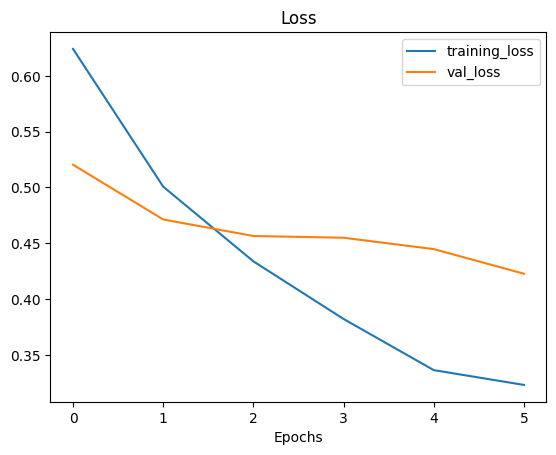

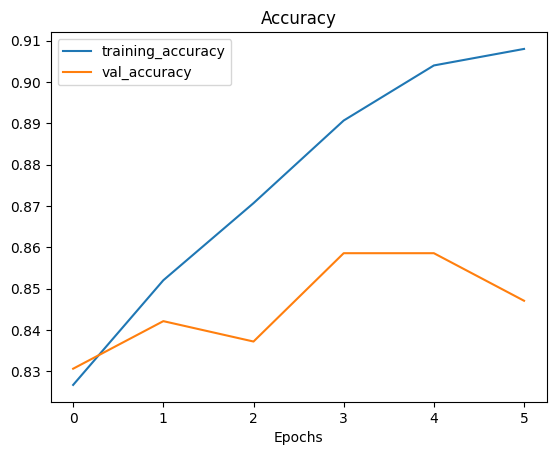

In [ ]:
#Check out the loss curves of our fine_tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compate one series of running `fit()` with another (e.g. before and after fine-tuning.

In [ ]:
#Let's create a function to compare training history
def compare_historys(original_history,new_history,initial_epochs=5):
  """
  Compares two TensorFlow history objects.
  """
  #get original history measurements
  acc = original_history.history['accuracy']
  loss= original_history.history['loss']

  val_acc=original_history.history['val_accuracy']
  val_loss=original_history.history['val_loss']

  #Combine original history metrics with new_history metrics
  total_acc=acc+new_history.history['accuracy']
  total_loss=loss+new_history.history['loss']
  total_val_acc=val_acc+new_history.history['val_accuracy']
  total_val_loss=val_loss+new_history.history['val_loss']

  # Make plots
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc,label="Training Accuracy")
  plt.plot(total_val_acc,label='Val Accuracy')
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title("Training and Validation Accuracy")

  # Make plots for loss
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss,label="Training Loss")
  plt.plot(total_val_loss,label='Val Loss')
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title("Training and Validation Loss")

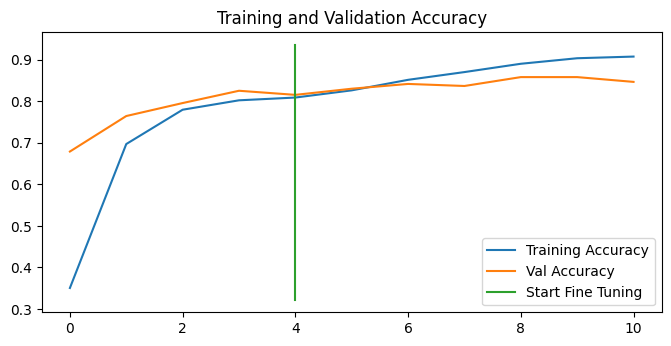

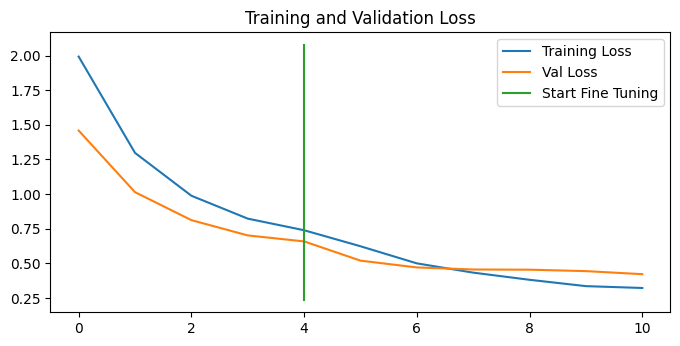

In [ ]:
compare_historys(history_2,
                 history_fine_10_percent_data_aug,
                 initial_epochs=5)

## Model 4: Fine-tuning and existing model on all of the data

In [ ]:
#Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2023-06-22 10:02:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 142.250.103.128, 108.177.121.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   263MB/s    in 1.9s    

2023-06-22 10:02:19 (263 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# Setup training and test dir
train_dir_all="10_food_classes_all_data/train"
test_dir="10_food_classes_all_data/test"

In [ ]:
#How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE=(224,224)
train_data_10_classes_full=tf.keras.preprocessing.image_dataset_from_directory(train_dir_all,
                                                                               label_mode='categorical',

                                                                               image_size=IMG_SIZE
                                                                               )
test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode='categorical',
                                                              image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments (all experiments have used the same test dataset).

Let's verify this....


In [ ]:
#Evaluate model 2 (this is the fine tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 6s 69ms/step - loss: 0.4345 - accuracy: 0.8536


[0.43447133898735046, 0.853600025177002]

In [ ]:
results_fine_tune_10_percent

[0.4344712495803833, 0.853600025177002]

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights.



In [ ]:
# load model from checkpoint, that way we can fine-tune from the smae stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

ValueError: ignored

In [ ]:
#Let's evaluate the model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.6277 - accuracy: 0.8392


[0.6276813745498657, 0.8392000198364258]

In [ ]:
#Check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.6276814937591553, 0.8392000198364258]

Alright, the previous steps might seem quite confusing but all we've done is:
1. Trained a feature extraction transfer learning model for 5 epochs  on 10% of the data with data augmentation (model_2) and we saved the model's weights using `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epocs with the top 10 layers of the base model unfrozen (model_3)
3. Saved the results and training logs each time.
4. Reloaded the model from step 1  to do the same steps as step 2 except this time we're going to use all of the data(model_4)

In [ ]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number,layer.name,layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [ ]:
# Let's drill into our base_model (efficientnetb0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number,layer.name,layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
#Compile
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])



In [ ]:
# Continue to train and fine tune the model to our data (100% of training data)
fine_tune_epochs=initial_epochs+5

history_fine_10_classes_full=model_2.fit(train_data_10_classes_full,
                                         epochs=fine_tune_epochs,
                                         validation_data=test_data,
                                         validation_steps=int(0.25*len(test_data)),
                                         initial_epoch=history_2.epoch[-1],
                                         callbacks=[create_tensorboard_callback("transfer_learning","full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20230622-100826
Epoch 5/10
235/235 [==============================] - 78s 287ms/step - loss: 0.6569 - accuracy: 0.7887 - val_loss: 0.3135 - val_accuracy: 0.8914
Epoch 6/10
235/235 [==============================] - 57s 242ms/step - loss: 0.5307 - accuracy: 0.8300 - val_loss: 0.2987 - val_accuracy: 0.9013
Epoch 7/10
235/235 [==============================] - 53s 222ms/step - loss: 0.4649 - accuracy: 0.8501 - val_loss: 0.3084 - val_accuracy: 0.8931
Epoch 8/10
235/235 [==============================] - 49s 207ms/step - loss: 0.4249 - accuracy: 0.8607 - val_loss: 0.2940 - val_accuracy: 0.8931
Epoch 9/10
235/235 [==============================] - 47s 200ms/step - loss: 0.3927 - accuracy: 0.8725 - val_loss: 0.2329 - val_accuracy: 0.9079
Epoch 10/10
235/235 [==============================] - 43s 179ms/step - loss: 0.3633 - accuracy: 0.8845 - val_loss: 0.2907 - val_accuracy: 0.8898


In [ ]:
#Let's evaluate on all of the test data
results_fine_tune_full_data=model_2.evaluate(test_data)

79/79 [==============================] - 7s 80ms/step - loss: 0.2812 - accuracy: 0.9056


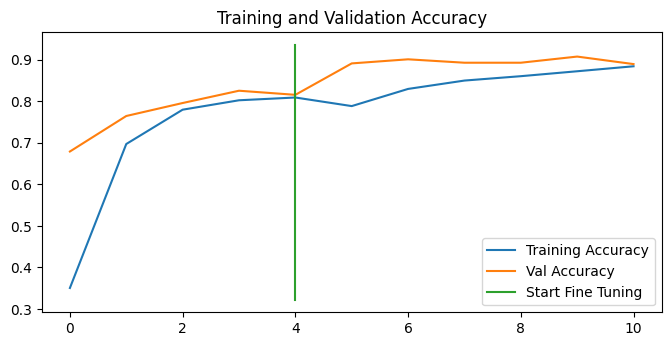

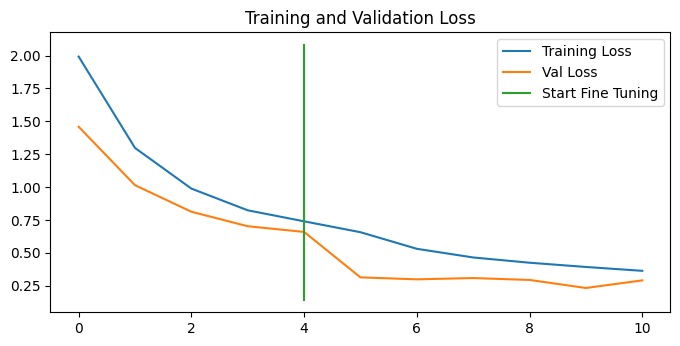

In [ ]:
#How did fine-tuning go with more data?
compare_historys(history_2,history_fine_10_classes_full,
                 initial_epochs=5)

## Viewing our experiment data on TensorBoard

> 🗝️**Note:** Anything you upload to TensorBoard.dev is going to be public. So, if you have private data, do not upload

In [ ]:
#View tensorboard logs of transfer learning modelling experiments (should ~4 models)
#Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
--name "Transfer Learning Experiments with 10 Food101 Classes" \
--description "A series of different transfer learning experiments with varying amounts of data and fine-tuning." \
--one_shot #exits the uploader once its finished uploading

My TensorBoard experiments are available at: https://tensorboard.dev/experiment/0pLeR6DVTbGl0pibMdTYNA/

In [ ]:
!tensorboard dev list

In [ ]:
# TO delete an experiment
!tensorboard dev delete --experiment_id id